In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
#为了在jupyter notebook里画图
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.0.0
sys.version_info(major=3, minor=6, micro=11, releaselevel='final', serial=0)
matplotlib 3.3.3
numpy 1.19.4
pandas 1.1.4
sklearn 0.23.2
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [2]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
print(housing.DESCR)#打印数据的description
print(housing.data.shape)#数据的大小，data相当于上一个例子中的x
print(housing.target.shape)#相当于上例中的y

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [3]:
#切分训练集和测试集
from sklearn.model_selection import train_test_split
#使用sklearn中的train_test_split函数切分
x_train_all, x_test, y_train_all, y_test=train_test_split(
    housing.data, housing.target, random_state = 7)
#random_state是随机种子
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_all,y_train_all,random_state = 11,test_size=0.25)
#拆分训练集和验证集
#默认情况下，train_test_split会把总体数据按照三比一的比例划分
#如果需要改变，可以使用test_size参数，默认参数值为0.25
print(x_train.shape, y_train.shape)#训练集
print(x_valid.shape, y_valid.shape)#验证集
print(x_test.shape, y_test.shape)#测试集

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [4]:
#进行数据的归一化
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()#初始化对象

x_train_scaled = scaler.fit_transform(x_train)
#选择在训练集上调用是因为需要在训练集上获得均值和方差，在
#测试集和验证集上，用与训练集上相同的均值和方差
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)
#完成数据集的归一化

In [5]:
#搭建模型

#多输入
#选前五个feature当wide部分的输入，后六个feature当作deep部分的输入
#一共8个feature,所以wide部分和deep部分有交集
input_wide = keras.layers.Input(shape=[5])
input_deep = keras.layers.Input(shape=[6])
hidden1 = keras.layers.Dense(30, activation='relu')(input_deep)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
concat = keras.layers.concatenate([input_wide, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs = [input_wide,input_deep],
                          outputs = [output])
    
    
model.summary()#打印model信息
model.compile(loss="mean_squared_error", optimizer="sgd")
callbacks = [keras.callbacks.EarlyStopping(
    patience=5, min_delta=1e-2)]
#调整min_delta的值，可以改变阈值，改小更快停止，改大更慢停止
#对model进行编译，目标函数使用均方差，即其平方和的均值
#上面的loss和optimizer使用的是字符串，事实上还存在着
#字符串到真正的函数的映射，以后可以自己编写函数

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 30)           210         input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 30)           930         dense[0][0]                      
______________________________________________________________________________________________

In [6]:
#调用fit 函数
#输入数据变成了两个，对训练数据进行拆分
x_train_scaled_wide = x_train_scaled[:, :5]
x_train_scaled_deep = x_train_scaled[:, 2:]
x_valid_scaled_wide = x_valid_scaled[:, :5]
x_valid_scaled_deep = x_valid_scaled[:, 2:]
x_test_scaled_wide = x_test_scaled[:, :5]
x_test_scaled_deep = x_test_scaled[:, 2:]


history = model.fit([x_train_scaled_wide,x_train_scaled_deep],
                    y_train,
                   validation_data = (
                       [x_valid_scaled_wide,x_valid_scaled_deep],
                        y_valid),
                    epochs = 100,
                    callbacks = callbacks
                   )
#先加入训练集的数据，再加入验证集，epoch是遍历数据集的次数

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 4s 331us/sample - loss: 0.8788 - val_loss: 0.9157
Epoch 2/100
11610/11610 [==============================] - 2s 200us/sample - loss: 0.6101 - val_loss: 0.5782
Epoch 3/100
11610/11610 [==============================] - 2s 199us/sample - loss: 0.4728 - val_loss: 0.4691
Epoch 4/100
11610/11610 [==============================] - 2s 202us/sample - loss: 0.4486 - val_loss: 0.4510
Epoch 5/100
11610/11610 [==============================] - 2s 204us/sample - loss: 0.4285 - val_loss: 0.4361
Epoch 6/100
11610/11610 [==============================] - 3s 237us/sample - loss: 0.4155 - val_loss: 0.4191
Epoch 7/100
11610/11610 [==============================] - 3s 239us/sample - loss: 0.4000 - val_loss: 0.4180
Epoch 8/100
11610/11610 [==============================] - 3s 238us/sample - loss: 0.3894 - val_loss: 0.4040
Epoch 9/100
11610/11610 [==============================] - 3s 236us/sample - lo

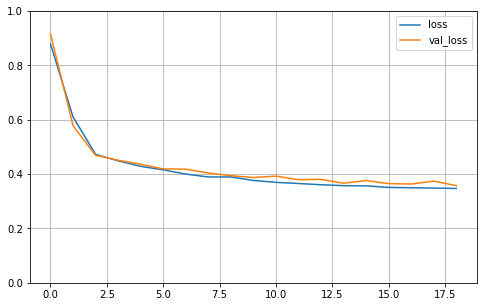

In [7]:
#打印运行结果
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()

plot_learning_curves(history)
    

In [8]:
#在测试集上运行
model.evaluate([x_test_scaled_wide, x_test_scaled_deep],y_test)

5160/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.3480052806610285